In [1]:
import pandas as pd
import pymysql
import matplotlib.pyplot as plt
import numpy as np        
import glob

### Exercise 1

In [34]:
class BabyNames:
    #1a
    def __init__(self, path):
        import glob
        import pandas as pd
        paths = glob.glob(path + '*.TXT')
        self.df = pd.DataFrame()
        for i, path in enumerate(paths):
            data = pd.read_csv(path, sep=",", header=None, names = ['state', 'gender', 'year', 'name', 'num'])
            self.df = self.df.append(data)

    
    #1b
    def Count(self,state=None, year=None):
        if state is None and year is not None:
            return self.df[year].count()
        elif year is None and state is not None:
            return self.df[state].count()
        elif state is None and year is None:
            return self.df.shape[0]
        else:
            return self.df[(self.df.state == state) & (self.df.year == year)]
        
    #1c
    def Top10BabyNames(self,state='IL', year=2015):
        self.rank = pd.DataFrame()
        if state is None and year is not None:
            self.rank['Rank'] = pd.Series(range(1, 11))
            self.rank['Male'] = self.df[(self.df.year == year) & (self.df.gender == 'M')].sort_values(by = 'num', ascending = False)['name'].values[:10]
            self.rank['Female'] = self.df[(self.df.year == year) & (self.df.gender == 'F')].sort_values(by = 'num', ascending = False)['name'].values[:10]
            self.rank.reset_index(drop=True)
            
        elif year is None and state is not None:
            self.rank['Rank'] = pd.Series(range(1, 11))
            self.rank['Male'] = self.df[(self.df.state == state) & (self.df.gender == 'M')].sort_values(by = 'num', ascending = False)['name'].values[:10]
            self.rank['Female'] = self.df[(self.df.state == state) & (self.df.gender == 'F')].sort_values(by = 'num', ascending = False)['name'].values[:10]
            self.rank.reset_index(drop=True)
        
        elif state is None and year is None:
            self.rank['Rank'] = pd.Series(range(1, 11))
            self.rank['Male'] = self.df[(self.df.gender == 'M')].sort_values(by = 'num', ascending = False)['name'].values[:10]
            self.rank['Female'] = self.df[(self.df.gender == 'F')].sort_values(by = 'num', ascending = False)['name'].values[:10]
            self.rank.reset_index(drop=True)
   
        else:
            self.rank['Rank'] = pd.Series(range(1, 11))
            self.rank['Male'] = self.df[(self.df.state == state) & (self.df.year == year) & (self.df.gender == 'M')].sort_values(by = 'num', ascending = False)['name'].values[:10]
            self.rank['Female'] = self.df[(self.df.state == state) & (self.df.year == year) & (self.df.gender == 'F')].sort_values(by = 'num', ascending = False)['name'].values[:10]
            self.rank.reset_index(drop=True)
            
        return self.rank
    
    #1d
    def ChangeOfPopularity(self,fromYear=2014, toYear=2015, top=10):
        #create variables
        self.fromyear_df = self.df[self.df.year == fromYear].groupby(['name']).agg({'num':'sum'})
        self.toyear_df = self.df[self.df.year == toYear].groupby(['name']).agg({'num':'sum'})
        self.name = pd.merge(self.fromyear_df,self.toyear_df,how = 'outer', on = 'name').fillna(0).diff(axis = 1).drop(['num_x'],axis = 1)
        self.increase = self.name.sort_values(by = 'num_y', ascending = False)[:top]
        self.decrease = self.name.sort_values(by = 'num_y', ascending = True)[:top]
        self.same = self.name[self.name.num_y == 0].drop(['num_y'],axis = 1)
        return self.increase, self.decrease, self.same

    #1e
    def Top5NamesPerYear(self, year=2015, sex=None):
        self.top5 = pd.DataFrame(columns=['State', 'Rank1', 'Num', 'Rank2', 'Num', 'Rank3', 'Num', 'Rank4', 'Num', 'Rank5', 'Num'])
        i = 0
        for s in pd.Series.unique(self.df['state']):
            #different code for whether sex is none or not
            if sex is None:
                names = self.df[(self.df.state == s) & (self.df.year == year)].sort_values(by = 'num', ascending = False)['name'].values[:5]
            else:
                names = self.Top10BabyNames(s, year)[sex].values[:5]

            counts = [self.df[((self.df.name == n) & (self.df.year == year) & (self.df.state == s))]['num'].values[0] for n in names]
            #add new row to dataframe
            self.top5.loc[i] = [s, names[0], counts[0], names[1], counts[1], names[2], counts[2], names[3], counts[3], names[4], counts[4]]
            i = i + 1
            
        self.top5 = self.top5.sort_values(by = 'State', ascending = True)
        
        return self.top5
    
    #1f
    def NamePopularityPlot(self,name='Michael', yearRange=(2000,2015), state='IL', sex='M'):
        self.base = self.df[(self.df.name == name) & (self.df.state == state) & (self.df.gender == sex)]
        self.series = list(range(yearRange[0],yearRange[1]+1))
        self.name_popu = []
        for year in self.series:
            self.total = self.df[(self.df.state == state) & (self.df.gender == sex) & (self.df.year == 1917)]['num'].sum()
            if len(self.base[self.base.year == year]['num']) != 0:
                self.popularity = self.base[self.base.year == year]['num'].values[0] * 100 / self.total
            if len(self.base[self.base.year == year]['num']) == 0:
                self.popularity = 0
            self.name_popu.append(self.popularity)
        plt.plot(self.series,self.name_popu,color = 'salmon')
        plt.xticks(np.arange(min(self.series), max(self.series)+1, 1.0))
        plt.show()
    
    #1g
    def NameFlip(self, n=10):
        import matplotlib.pyplot as plt
        import matplotlib as mpl
        #create return variable
        self.flip = pd.DataFrame(columns=['Name', 'Count'])
        #group the data by name
        group_byname = self.df.groupby('name')
        #group_sorted = sorted(group_byname, key=lambda x: x[1].num.sum(), reverse=True)
        #count number of flip for each group
        for byname in group_byname:
            genders = byname[1].gender.values 
            if 'F' in genders and 'M' in genders:       
                #count number of flips
                gender_str = ''.join(genders)
                flips = gender_str.count('FM') + gender_str.count('MF')
                #add new one to dataframe
                self.flip = self.flip.append({'Name': str(byname[0]), 'Count': flips}, ignore_index=True)
        #get top n
        self.flip = self.flip.sort_values(by = 'Count', ascending = False).head(n)
        #plot
        for f in self.flip.iterrows():
            grp = self.df[(self.df.name == f[1].Name)].groupby(['year', 'gender'])
            sums = grp.num.sum().reset_index()
            mpl.style.use('seaborn')
            fig, ax = plt.subplots(figsize=(6, 4))
            ax.set_title(f[1].Name.format('seaborn'))
            ax.plot(sums[(sums.gender == 'F')]['year'], sums[(sums.gender == 'F')]['num'], 'orange', label='Female')
            ax.plot(sums[(sums.gender == 'M')]['year'], sums[(sums.gender == 'M')]['num'], 'darkblue', label='Male')
            ax.legend()
            plt.show()
        return pd.DataFrame(self.flip.Name)

In [35]:
path = '/Users/irinayiweizhang/Desktop/MSiA422/hw/project/namesbystate/'
baby = BabyNames(path)

In [5]:
baby.Count()

5933561

In [6]:
baby.Top10BabyNames()

,Rank,Male,Female
0,1,Noah,Olivia
1,2,Liam,Emma
2,3,Alexander,Sophia
3,4,Jacob,Mia
4,5,Michael,Isabella
5,6,Benjamin,Ava
6,7,William,Sofia
7,8,Daniel,Abigail
8,9,Mason,Emily
9,10,James,Amelia


In [26]:
baby.ChangeOfPopularity()

(            num_y
 name             
 Oliver     2221.0
 Alexa      1795.0
 Hazel      1392.0
 Mia        1386.0
 Matteo     1354.0
 Grayson    1348.0
 Charlotte  1279.0
 Mateo      1272.0
 Lincoln    1203.0
 Scarlett   1122.0,             num_y
 name             
 Jayden    -1571.0
 Isabella  -1474.0
 Jase      -1451.0
 Sophia    -1201.0
 Joshua    -1105.0
 Annabelle -1088.0
 Andrew    -1055.0
 Michael   -1022.0
 Peyton    -1020.0
 Alexis    -1006.0, Empty DataFrame
 Columns: []
 Index: [Aadit, Aalayah, Aamina, Abdirizak, Abdoulaye, Abdurrahman, Abner, Abriana, Abyan, Adaeze, Adhya, Advith, Aela, Ainsleigh, Aissatou, Aiza, Alazne, Alexey, Alexys, Alizay, Allyzon, Altair, Amaiyah, Amanuel, Amariyah, Ambrielle, Amel, Amery, Amorie, Amreen, Amrita, Anagha, Anahit, Anasophia, Anely, Angus, Anjel, Annalicia, Anwar, Anyah, Anyiah, Ara, Areej, Arella, Arhaan, Arielis, Ariely, Arionna, Arleen, Arlen, Armond, Arye, Asadbek, Ashleen, Ashlin, Assata, Athanasios, Aura, Austen, Auston, Avaline, A

In [36]:
baby.Top5NamesPerYear()

,State,Rank1,Num,Rank2,Num,Rank3,Num,Rank4,Num,Rank5,Num
38,AK,Olivia,56,Liam,53,Emma,49,Noah,48,Aurora,46
34,AL,William,413,James,322,John,318,Ava,298,Mason,294
16,AR,Emma,214,William,197,Elijah,172,Mason,171,Olivia,171
28,AZ,Sophia,474,Mia,464,Emma,450,Noah,445,Olivia,420
36,CA,Sophia,2954,Mia,2861,Noah,14,Emma,2720,Jacob,2556
7,CO,Emma,355,Olivia,347,Liam,306,William,276,Jackson,271
37,CT,Sophia,217,Noah,216,Mason,211,Emma,203,Olivia,201
45,DC,William,78,Henry,75,James,68,Alexander,64,Jacob,62
50,DE,Ava,69,Noah,60,Liam,60,Mason,60,Olivia,59
47,FL,Isabella,1380,Liam,1279,Noah,7,Emma,1224,Sophia,1176


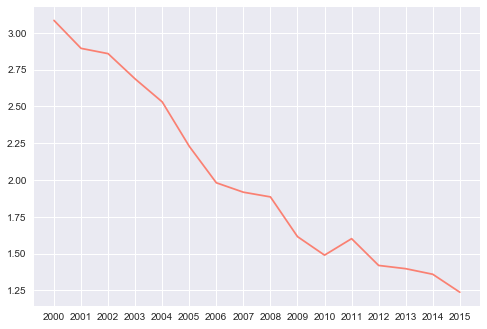

In [28]:
baby.NamePopularityPlot()

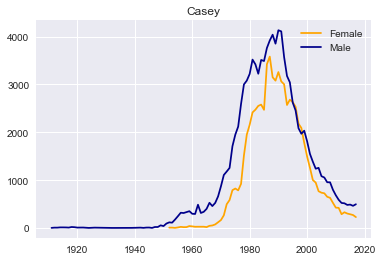

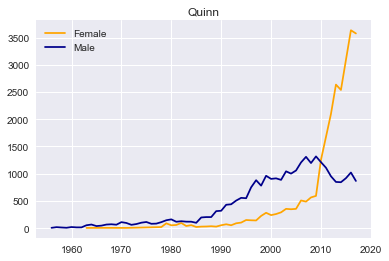

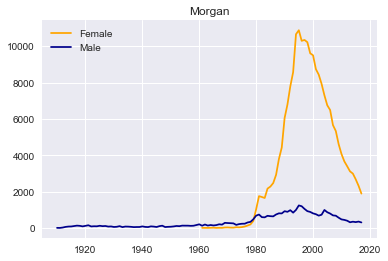

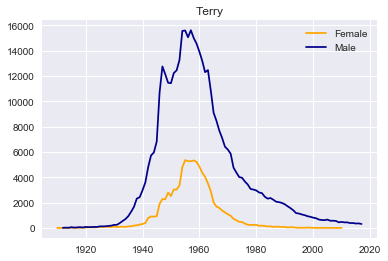

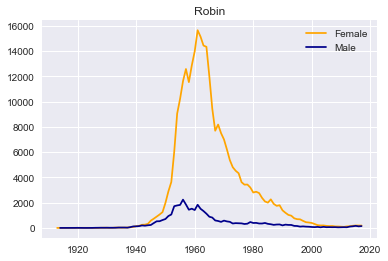

,Name
528,Casey
2355,Quinn
2136,Morgan
2764,Terry
2461,Robin


In [7]:
baby.NameFlip(n=5)

In [16]:
#other story
paths = glob.glob(path + '*.TXT')
path = '/Users/chensi/Desktop/Python & Java/Homework/Project 1/namesbystate/'
df = pd.DataFrame()
for path in paths:
    data = pd.read_csv(path, sep=",", header=None, names = ['state', 'gender', 'year', 'name', 'num'])
    df = df.append(data)

In [19]:
#The function show the difference between the most and least popular names of a gender in a state over a specific time period
def DifferenceOnNames(fromyear,toyear,state,gender):
    xaxis = list(range(int(fromyear),int(toyear)))
    yaxis = []
    for year in xaxis:
        diff = df[(df.state == state) & (df.gender == gender) & (df.year == year)]['num'].max() - df[(df.state == state) & (df.gender == gender) & (df.year == year)]['num'].min()
        yaxis.append(diff)
    plt.plot(xaxis,yaxis,color = 'orchid')
    plt.show

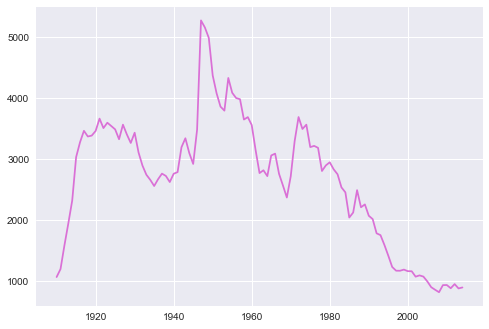

In [20]:
DifferenceOnNames(1910,2015,'IL','F')

### Exercise 2

### 2.1
This query returns the information of the top 10 countries whose population is larger than 50 million in descending order in terms of population.

The results from sql and pandas are the same

In [25]:
#sql server setup
cnx = pymysql.connect(user='root', \
      password='', \
      host= '127.0.0.1', \
      port=3306, \
      db='world', \
      autocommit=True)
#prepare the data 
country = pd.read_sql_query('select * from country', con=cnx)

In [72]:
#pandas result
country[(country.Population > 50000000)].sort_values(by='Population', ascending=False)[:10]

,Code,Name,Continent,Region,SurfaceArea,IndepYear,Population,LifeExpectancy,GNP,GNPOld,LocalName,GovernmentForm,HeadOfState,Capital,Code2
41,CHN,China,Asia,Eastern Asia,9572900.0,-1523.0,1277558000,71.4,982268.0,917719.0,Zhongquo,People'sRepublic,Jiang Zemin,1891.0,CN
99,IND,India,Asia,Southern and Central Asia,3287263.0,1947.0,1013662000,62.5,447114.0,430572.0,Bharat/India,Federal Republic,Kocheril Raman Narayanan,1109.0,IN
223,USA,United States,North America,North America,9363520.0,1776.0,278357000,77.1,8510700.0,8110900.0,United States,Federal Republic,George W. Bush,3813.0,US
98,IDN,Indonesia,Asia,Southeast Asia,1904569.0,1945.0,212107000,68.0,84982.0,215002.0,Indonesia,Republic,Abdurrahman Wahid,939.0,ID
30,BRA,Brazil,South America,South America,8547403.0,1822.0,170115000,62.9,776739.0,804108.0,Brasil,Federal Republic,Fernando Henrique Cardoso,211.0,BR
164,PAK,Pakistan,Asia,Southern and Central Asia,796095.0,1947.0,156483000,61.1,61289.0,58549.0,Pakistan,Republic,Mohammad Rafiq Tarar,2831.0,PK
181,RUS,Russian Federation,Europe,Eastern Europe,17075400.0,1991.0,146934000,67.2,276608.0,442989.0,Rossija,Federal Republic,Vladimir Putin,3580.0,RU
21,BGD,Bangladesh,Asia,Southern and Central Asia,143998.0,1971.0,129155000,60.2,32852.0,31966.0,Bangladesh,Republic,Shahabuddin Ahmad,150.0,BD
109,JPN,Japan,Asia,Eastern Asia,377829.0,-660.0,126714000,80.7,3787042.0,4192638.0,Nihon/Nippon,Constitutional Monarchy,Akihito,1532.0,JP
155,NGA,Nigeria,Africa,Western Africa,923768.0,1960.0,111506000,51.6,65707.0,58623.0,Nigeria,Federal Republic,Olusegun Obasanjo,2754.0,NG


In [73]:
#pandas result
population.sort_values(by='Population', ascending=False)

#sql result
population = pd.read_sql_query('select * from country where population > 50000000 order by population DESC limit 10', con=cnx, index_col='Code')
population

,Name,Continent,Region,SurfaceArea,IndepYear,Population,LifeExpectancy,GNP,GNPOld,LocalName,GovernmentForm,HeadOfState,Capital,Code2
Code,,,,,,,,,,,,,,
CHN,China,Asia,Eastern Asia,9572900.0,-1523,1277558000,71.4,982268.0,917719.0,Zhongquo,People'sRepublic,Jiang Zemin,1891,CN
IND,India,Asia,Southern and Central Asia,3287263.0,1947,1013662000,62.5,447114.0,430572.0,Bharat/India,Federal Republic,Kocheril Raman Narayanan,1109,IN
USA,United States,North America,North America,9363520.0,1776,278357000,77.1,8510700.0,8110900.0,United States,Federal Republic,George W. Bush,3813,US
IDN,Indonesia,Asia,Southeast Asia,1904569.0,1945,212107000,68.0,84982.0,215002.0,Indonesia,Republic,Abdurrahman Wahid,939,ID
BRA,Brazil,South America,South America,8547403.0,1822,170115000,62.9,776739.0,804108.0,Brasil,Federal Republic,Fernando Henrique Cardoso,211,BR
PAK,Pakistan,Asia,Southern and Central Asia,796095.0,1947,156483000,61.1,61289.0,58549.0,Pakistan,Republic,Mohammad Rafiq Tarar,2831,PK
RUS,Russian Federation,Europe,Eastern Europe,17075400.0,1991,146934000,67.2,276608.0,442989.0,Rossija,Federal Republic,Vladimir Putin,3580,RU
BGD,Bangladesh,Asia,Southern and Central Asia,143998.0,1971,129155000,60.2,32852.0,31966.0,Bangladesh,Republic,Shahabuddin Ahmad,150,BD
JPN,Japan,Asia,Eastern Asia,377829.0,-660,126714000,80.7,3787042.0,4192638.0,Nihon/Nippon,Constitutional Monarchy,Akihito,1532,JP


### 2.2
This query intends to return the continent name, number of countries and population for each continent whose population is not 0, order by continent name in ascending order. 

The result are the same, except for the fact that the population generated by sql is shown in power of 10, but the result by pandas is in integer. 

In [74]:
#result from pandas
def get_conti(group):
    group['Num_countries'] = group['Population'].count()
    group['population'] = group['Population'].sum()
    return group

country_count = country.groupby(['Continent']).apply(get_conti)
count_result = country_count[(country.Population > 0)].loc[:, country_count.columns.isin(['Continent', 'Num_countries','population'])].drop_duplicates()
count_result.sort_values(by='Continent', ascending=True)


,Continent,Num_countries,population
2,Africa,58,784475000
1,Asia,51,3705025700
4,Europe,46,730074600
0,North America,37,482993000
10,Oceania,28,30401150
8,South America,14,345780000


In [75]:
#result from sql
conti = pd.read_sql_query('select Continent, count(*) As Number_Countries, sum(population) As Population from country where population > 0 group by Continent order by 1 ASC', con = cnx)
conti                                                  

,Continent,Number_Countries,Population
0,Asia,51,3.705026e+09
1,Europe,46,7.300746e+08
2,North America,37,4.829930e+08
3,Africa,57,7.844750e+08
4,Oceania,27,3.040115e+07
5,South America,14,3.457800e+08


### 2.3
This query returns population and city name of the top 10 cities in USA that has the largest population, in descending order. The cities also have to be in the country dataset.

Pandas and sql results are the same

In [94]:
#pandas result
city = pd.read_sql_query('select * from city', con = cnx)
country_usa = country[(country.Code == 'USA')]
merged = pd.merge(city, country_usa, how='inner', left_on=['CountryCode'], right_on=['Code'])
merged = merged.rename(columns = {'Name_x': 'City', 'Population_x': 'Population'})
merged.sort_values(by='Population', ascending=False).loc[:, merged.columns.isin(['City', 'Population'])][:10]

,City,Population
0,New York,8008278
1,Los Angeles,3694820
2,Chicago,2896016
3,Houston,1953631
4,Philadelphia,1517550
5,Phoenix,1321045
6,San Diego,1223400
7,Dallas,1188580
8,San Antonio,1144646
9,Detroit,951270


In [50]:
#sql result
pop_city = pd.read_sql_query('select city.Name As City, city.population from city inner join country ON city.CountryCode = country.code where country.code = "USA" order by city.population DESC limit 10', con = cnx)
pop_city

,City,population
0,New York,8008278
1,Los Angeles,3694820
2,Chicago,2896016
3,Houston,1953631
4,Philadelphia,1517550
5,Phoenix,1321045
6,San Diego,1223400
7,Dallas,1188580
8,San Antonio,1144646
9,Detroit,951270


### 2.4
This query selects the top 10 spoken official languages ordered by number of people speaking it by country in descending order, along with the population speaks it and their corresponding country. The countries that the language is spoken has to be in the country dataset.

The pandas and sql results are the same

In [102]:
#pandas result
lang = pd.read_sql_query('select * from countrylanguage', con=cnx)
lang_pop = pd.merge(lang[(lang.IsOfficial == 'T')], country, how='inner', left_on=['CountryCode'], right_on=['Code'])
lang_pop['spoken_pop'] = lang_pop['Percentage'] * lang_pop['Population'] / 100
lang_pop.sort_values(by='spoken_pop', ascending=False).loc[:, lang_pop.columns.isin(['Name', 'Language', 'spoken_pop'])][:10]


,Language,Name,spoken_pop
45,Chinese,China,1.175353e+09
92,Hindi,India,4.044511e+08
218,English,United States,2.399437e+08
33,Portuguese,Brazil,1.658621e+08
175,Russian,Russian Federation,1.272448e+08
22,Bengali,Bangladesh,1.261844e+08
102,Japanese,Japan,1.255736e+08
132,Spanish,Mexico,9.106940e+07
57,German,Germany,7.501637e+07
225,Vietnamese,Vietnam,6.929418e+07


In [95]:
#sql result
pd.read_sql_query('select country.Name, Language, (Percentage * population) / 100 from countrylanguage inner join country on countrylanguage.CountryCode = country.code where IsOfficial = True order by 3 DESC limit 10', con = cnx)


,Name,Language,(Percentage * population) / 100
0,China,Chinese,1.175353e+09
1,India,Hindi,4.044512e+08
2,United States,English,2.399437e+08
3,Brazil,Portuguese,1.658621e+08
4,Russian Federation,Russian,1.272448e+08
5,Bangladesh,Bengali,1.261844e+08
6,Japan,Japanese,1.255736e+08
7,Mexico,Spanish,9.106940e+07
8,Germany,German,7.501637e+07
9,Vietnam,Vietnamese,6.929418e+07


### 2.5 
This query selects the top 5 spoken languages worldwide (total population speaking it all over the world), along with the spoken population, ordered by the population speaking it in descending order. 

The pandas and sql results are the same.

In [113]:
#pandas result
#new df including the unofficial languages
lang_pop2 = pd.merge(lang, country, how='inner', left_on=['CountryCode'], right_on=['Code'])
lang_pop2['spoken_pop'] = lang_pop2['Percentage'] * lang_pop2['Population'] / 100

spoken = lang_pop2.groupby('Language').spoken_pop.sum().reset_index()
spoken.sort_values('spoken_pop', ascending=False)[:5]
#lang_pop.sort_values(by='spoken_pop', ascending=False).loc[:, lang_pop.columns.isin(['Name', 'Language', 'spoken_pop'])][:10]



,Language,spoken_pop
76,Chinese,1.191844e+09
163,Hindi,4.056331e+08
388,Spanish,3.550295e+08
109,English,3.470779e+08
14,Arabic,2.338392e+08


In [103]:
#sql result
pd.read_sql_query('select Language, sum((Percentage * population) / 100) from countrylanguage inner join country ON countrylanguage.CountryCode = country.code group by Language order by 2 desc limit 5', con = cnx)


,Language,sum((Percentage * population) / 100)
0,Chinese,1.191844e+09
1,Hindi,4.056331e+08
2,Spanish,3.550295e+08
3,English,3.470779e+08
4,Arabic,2.338392e+08
